In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd ..

/Share/home/shibinbin/projects/exRNA


In [41]:
import pandas as pd
import seaborn as sns
sns.set()
sns.set_style('whitegrid')
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from scipy.spatial.distance import pdist, squareform

In [13]:
def knn_score(X, y, K=10):
    N = X.shape[0]
    assert K < N
    nn = NearestNeighbors(K)
    nn.fit(X)
    
    distances, indices = nn.kneighbors(X, K + 1)
    neighbor_classes = np.take(y, indices[:, 1:])
    same_class_fractions = np.sum(neighbor_classes == y[:, np.newaxis], axis=1)
    classes, counts = np.unique(y, return_counts=True)
    classes = np.argmax(y.reshape((-1, 1)) == classes.reshape((1, -1)), axis=1)
    counts = np.take(counts, classes)
    mean_r = K/(N - 1)*counts
    max_r = np.minimum(K, counts)
    scores = (same_class_fractions - mean_r)/(max_r - mean_r)
    #print(scores)
    return scores.mean()

In [5]:
sample_classes = pd.read_table('metadata/sample_classes.GSE71008.txt', sep='\t', header=None,
                               names=['sample_id', 'label'], index_col=0).iloc[:, 0]
unique_classes = np.unique(sample_classes)
print('Unique classes: {}'.format(', '.join(unique_classes)))
sample_classes.head()

Unique classes: Colorectal Cancer, Healthy Control, Pancreatic Cancer, Prostate Cancer


sample_id
Sample_1S3     Colorectal Cancer
Sample_1S6     Colorectal Cancer
Sample_1S9     Colorectal Cancer
Sample_1S12    Colorectal Cancer
Sample_1S15    Colorectal Cancer
Name: label, dtype: object

In [7]:
m1 = pd.read_table('output/count_matrix/GSE71008_original.txt', sep='\t', index_col=0)
m2 = pd.read_csv('/home/chenxupeng/projects/training/data/gse_exp_ly.csv', index_col=0)
m1.columns = 'Sample_' + m1.columns

diff_matrix = np.zeros((m1.shape[1], m1.shape[1]), dtype=np.int32)
for i in range(m1.shape[1]):
    for j in range(m2.shape[1]):
        diff_matrix[i, j] = np.sum(np.abs(m1.iloc[:, i] - m2.iloc[:, j]))
sample_mappings = pd.DataFrame({
    'Sample1': m1.columns[:150].values,
    'Class1': sample_classes[m1.columns[:150]].values,
    'Sample2': m2.columns[np.argmin(diff_matrix, axis=1)[:150]].values,
    'Class2': sample_classes[m2.columns[np.argmin(diff_matrix, axis=1)[:150]]].values
}).reindex(columns=['Sample1', 'Class1', 'Sample2', 'Class2'])
sample_mappings.head(10)

,Sample1,Class1,Sample2,Class2
0,Sample_1S1,Colorectal Cancer,Sample_1S10,Colorectal Cancer
1,Sample_1S2,Colorectal Cancer,Sample_1S11,Colorectal Cancer
2,Sample_1S3,Colorectal Cancer,Sample_1S12,Colorectal Cancer
3,Sample_2S1,Colorectal Cancer,Sample_1S13,Colorectal Cancer
4,Sample_2S2,Colorectal Cancer,Sample_1S14,Colorectal Cancer
5,Sample_2S3,Colorectal Cancer,Sample_1S15,Colorectal Cancer
6,Sample_3S1,Colorectal Cancer,Sample_1S16,Colorectal Cancer
7,Sample_3S2,Colorectal Cancer,Sample_1S17,Colorectal Cancer
8,Sample_3S3,Colorectal Cancer,Sample_1S18,Colorectal Cancer
9,Sample_4S1,Colorectal Cancer,Sample_1S19,Colorectal Cancer


Map sample IDs from original count matrix (downloaded from GEO) to batch information

In [11]:
map_ids_1to2 = pd.Series(sample_mappings['Sample2'].values, index=sample_mappings['Sample1'].values)
map_ids_2to1 = pd.Series(sample_mappings['Sample1'].values, index=sample_mappings['Sample2'].values)
map_ids_1to2.to_csv('metadata/map_ids.GSE71008.txt', header=False, index=True, sep='\t')
map_ids_1to2.head()

Sample_1S1    Sample_1S10
Sample_1S2    Sample_1S11
Sample_1S3    Sample_1S12
Sample_2S1    Sample_1S13
Sample_2S2    Sample_1S14
dtype: object

In [36]:
counts_original = pd.read_table('output/count_matrix/GSE71008_original.txt', sep='\t', index_col=0)
counts_original.columns = 'Sample_' + counts_original.columns
cpm_original = counts_original*1e6/counts_original.sum(axis=0)
cpm_original = cpm_original.loc[:, map_ids_1to2.index.values]

In [77]:
counts = pd.read_table('output/count_matrix/GSE71008.txt', sep='\t', index_col=0)

In [101]:
counts_renamed = counts.copy()
counts_renamed.columns = map_ids_1to2[counts_renamed.columns.values]
counts_renamed.to_csv('output/count_matrix/GSE71008_renamed.txt', sep='\t', header=True, index=True, na_rep='NA')

In [27]:
cpm = pd.read_table('output/cpm_matrix/GSE71008.txt', sep='\t', index_col=0)
cpm = cpm.loc[np.mean(np.isclose(cpm, 0), axis=1) < 0.8]
cpm = cpm.loc[:, map_ids_1to2.index.values]

Remove outlier samples with very large distance to other samples

In [47]:
mean_dist = pd.Series(np.mean(squareform(pdist(cpm.T)), axis=1), index=cpm.columns.values)
mean_dist = mean_dist.sort_values(ascending=False)
mean_dist.head()

Sample_4S8     169099.509859
Sample_3S12     99424.255967
Sample_PC4      97310.943548
Sample_4S3      86046.639915
Sample_4S17     78764.384723
dtype: float64

In [49]:
cpm = cpm.drop(columns=['Sample_4S8'])

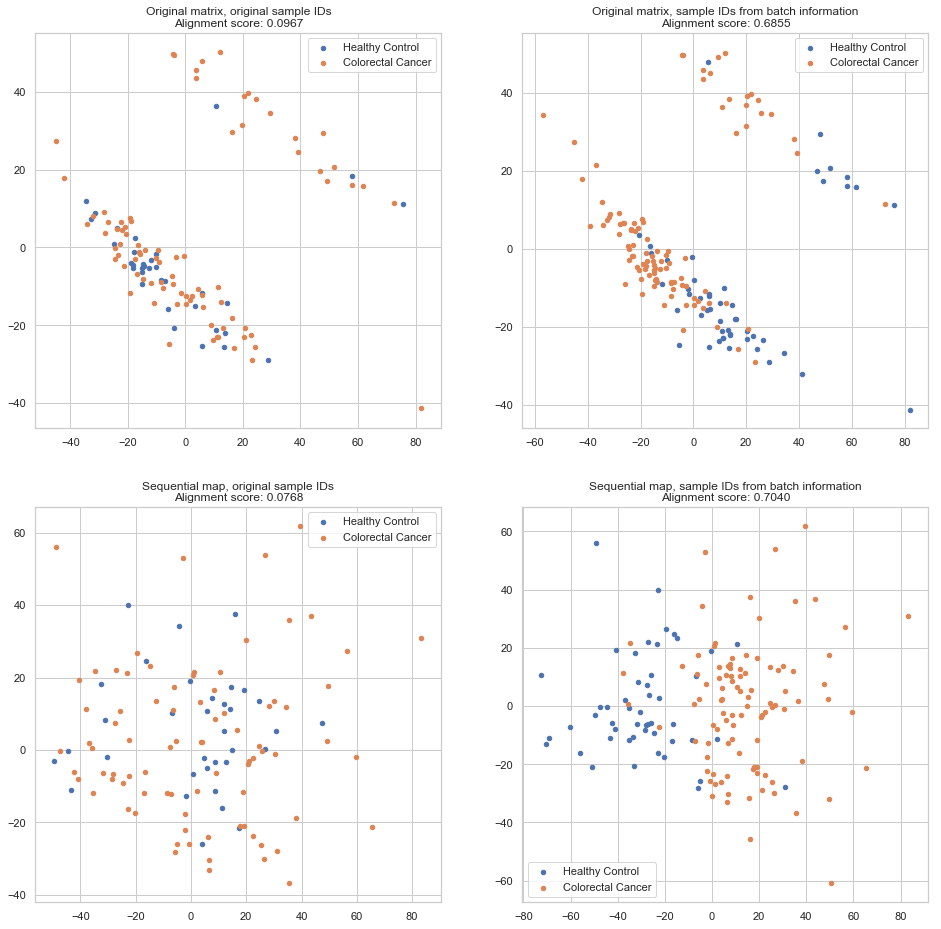

In [57]:
fig, axes = plt.subplots(3, 2, figsize=(16, 16))
for i_mat in range(2):
    m = [cpm_original, cpm][i_mat]
    X = np.log2(m + 0.001).T
    #X = cpm_original.T.copy()
    X = StandardScaler().fit_transform(X)
    #pca = TSNE(2)
    pca = PCA()
    #pca.fit(X)
    X_pca = pca.fit_transform(X)
    for i_id in range(2):
        ax = axes[i_mat, i_id]
        sample_ids = [[cpm_original.columns.values, map_ids_1to2[cpm_original.columns.values]],
                      [cpm.columns.values, map_ids_1to2[cpm.columns.values]]
                     ][i_mat][i_id]
        for label in ['Healthy Control', 'Colorectal Cancer']:
            indices = np.nonzero(sample_classes[sample_ids] == label)[0]
            ax.scatter(X_pca[indices, 0], X_pca[indices, 1], s=20, label=label)
        ax.legend()
        title = [['Original matrix, original sample IDs', 'Original matrix, sample IDs from batch information'],
                 ['Sequential map, original sample IDs', 'Sequential map, sample IDs from batch information']
                ][i_mat][i_id]
        ax.set_title('{}\nAlignment score: {:.4f}'.format(title,
                        knn_score(X, sample_classes[sample_ids].values)))

Text(0.5,1,'Sequential map, sample IDs from batch information\nAlignment score: 0.7040')

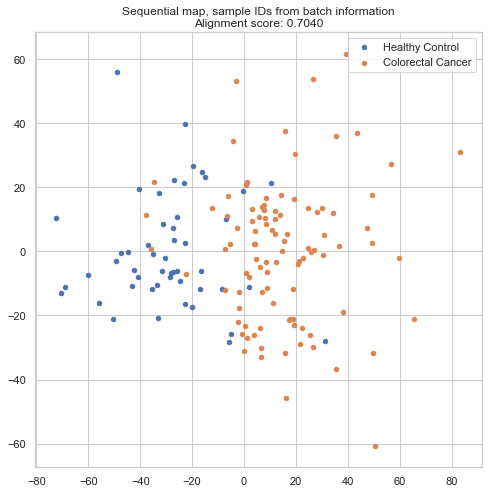

In [76]:
cpm2 = pd.read_table('output/cpm_matrix/cpm.scirep_sequential_qc.txt', sep='\t', index_col=0)
#cpm2.columns = map_ids_1to2[cpm2.columns.values]
sample_ids = cpm2.columns
m = cpm2
X = np.log2(m + 0.001).T
#X = cpm_original.T.copy()
X = StandardScaler().fit_transform(X)
#pca = TSNE(2)
pca = PCA()
fig, ax = plt.subplots(figsize=(8, 8))
for label in ['Healthy Control', 'Colorectal Cancer']:
    indices = np.nonzero(sample_classes[sample_ids] == label)[0]
    ax.scatter(X_pca[indices, 0], X_pca[indices, 1], s=20, label=label)
ax.legend()
ax.set_title('{}\nAlignment score: {:.4f}'.format(title,
                        knn_score(X_pca, sample_classes[sample_ids].values)))

In [75]:
cpm2.to_csv('output/cpm_matrix/cpm.scirep_sequential_qc.txt', sep='\t', header=True, index=True)

In [86]:
gse_sample_batch = pd.read_csv('/home/chenxupeng/projects/training/data/GSE_sample_batch.csv', index_col=0)
gse_sample_batch['sample'] = map_ids_1to2[gse_sample_batch['sample'].values].values
gse_sample_batch.to_csv('metadata/GSE71008.batch_info.txt', sep='\t', header=True, index=False)

In [63]:
(cpm*cpm.sum(axis=0)*1e-6).sort_values('Sample_1S1', ascending=False).head()

,Sample_1S1,Sample_1S2,Sample_1S3,Sample_2S1,Sample_2S2,Sample_2S3,Sample_3S1,Sample_3S2,Sample_3S3,Sample_4S1,...,Sample_PC29,Sample_PC30,Sample_N32,Sample_N34,Sample_1S19,Sample_2S19,Sample_2S20,Sample_2S21,Sample_3S19,Sample_3S20
transcript,,,,,,,,,,,,,,,,,,,,,
ENST00000384906.1|MIR99A-201|81,93602.911800,97041.672243,98920.165099,99032.065924,100961.930537,98924.018136,98483.583710,107100.269737,97246.830298,99769.911630,...,100181.166432,103010.840726,92358.698788,78583.859608,93886.583912,76378.685677,85917.104862,100092.922843,92770.288023,96007.089731
ENST00000385302.1|MIR320A-201|82,51122.562362,38206.377708,49016.711973,31183.452054,31405.507259,28667.975902,55888.559164,37118.962936,49781.559378,36182.903009,...,27666.161306,24722.749694,25749.379323,19499.647954,33036.672059,49710.992241,33542.253226,42011.421266,40085.995688,22662.371333
ENST00000362190.3|MIR22-201|85,49508.899679,41505.528270,50547.561162,38415.837043,41266.121644,32407.008243,56178.052287,43715.228948,47963.225177,45035.521622,...,39291.199117,33952.071803,34381.109687,29400.036499,42314.175372,59488.108869,42891.646918,49577.645711,50775.965869,33071.642219
ENST00000364908.1|Y_RNA.293-201|93,36314.121678,27800.546847,20935.168917,32401.435697,16034.357227,23002.447453,32387.595864,12465.919680,30041.185893,21649.283846,...,16757.545406,15798.369280,26243.126269,34977.613264,20363.953068,31268.226899,16963.878208,25397.514729,19893.382821,26348.390036
ENST00000385259.1|MIR100-201|80,33104.802287,31451.311576,37102.973861,31727.737515,31409.555002,31554.959408,28271.487443,34302.873371,30197.721018,29690.407929,...,29235.631570,30233.034748,30623.192156,24478.942941,29239.536254,27021.908299,26684.293379,31899.450655,28517.830193,27908.427325


In [64]:
counts.loc[:, map_ids_1to2.index.values].sort_values('Sample_1S1', ascending=False).head()

,Sample_1S1,Sample_1S2,Sample_1S3,Sample_2S1,Sample_2S2,Sample_2S3,Sample_3S1,Sample_3S2,Sample_3S3,Sample_4S1,...,Sample_PC29,Sample_PC30,Sample_N32,Sample_N34,Sample_1S19,Sample_2S19,Sample_2S20,Sample_2S21,Sample_3S19,Sample_3S20
transcript,,,,,,,,,,,,,,,,,,,,,
ENST00000384906.1|MIR99A-201|81,285914,328703,328194,316045,324256,447919,378635,430251,315593,370313,...,288900,362127,339508,217383,306944,233094,296640,325590,299799,351156
ENST00000385302.1|MIR320A-201|82,156156,129414,162626,99517,100864,129806,214872,149117,161555,134299,...,79783,86911,94654,53941,108007,151709,115809,136658,129543,82890
ENST00000362190.3|MIR22-201|85,151227,140589,167705,122598,132533,146736,215985,175616,155654,167157,...,113307,119356,126384,81328,138338,181547,148089,161270,164089,120963
ENST00000364908.1|Y_RNA.293-201|93,110923,94167,69458,103404,51497,104153,124519,50079,97492,80355,...,48325,55538,96469,96757,66576,95425,58570,82615,64288,96372
ENST00000385259.1|MIR100-201|80,101120,106533,123099,101254,100877,142878,108694,137804,98000,110201,...,84309,106282,112570,67715,95593,82466,92131,103765,92159,102078


In [110]:
batch_info = pd.read_excel('metadata/batch_info.GSE71008.xlsx')
batch_info['sampleID'] = 'Sample_' + batch_info['sampleID']
batch_info['sampleID'] = map_ids_1to2[batch_info['sampleID'].values].values
batch_info = batch_info.dropna()
batch_info.to_csv('metadata/batch_info.GSE71008.txt', sep='\t', header=True, index=False)

In [111]:
batch_info.head()

,sampleID,RNA Isolation batch,library prepration day,gel cut size selection
0,Sample_1S10,2,22,7
1,Sample_1S11,2,22,8
2,Sample_1S12,2,22,1
3,Sample_1S13,2,22,2
4,Sample_1S14,2,22,3


In [112]:
batch_info.shape

(150, 4)

In [114]:
batch_info = pd.read_excel('metadata/batch_info.GSE71008.xlsx')
batch_info['sampleID'] = 'Sample_' + batch_info['sampleID']
batch_info.head()

,sampleID,RNA Isolation batch,library prepration day,gel cut size selection
0,Sample_1S1,2,22,7
1,Sample_1S2,2,22,8
2,Sample_1S3,2,22,1
3,Sample_2S1,2,22,2
4,Sample_2S2,2,22,3


In [117]:
batch_info.sort_values('sampleID').head()

,sampleID,RNA Isolation batch,library prepration day,gel cut size selection
0,Sample_1S1,2,22,7
73,Sample_1S10,3,24,1
74,Sample_1S11,3,24,2
122,Sample_1S12,3,25,7
163,Sample_1S13,4,26,2


In [122]:
map_ids_1to2.head(10)

Sample_1S1    Sample_1S10
Sample_1S2    Sample_1S11
Sample_1S3    Sample_1S12
Sample_2S1    Sample_1S13
Sample_2S2    Sample_1S14
Sample_2S3    Sample_1S15
Sample_3S1    Sample_1S16
Sample_3S2    Sample_1S17
Sample_3S3    Sample_1S18
Sample_4S1    Sample_1S19
dtype: object

In [139]:
sample_classes2 = pd.read_table('tmp/sample_classes.GSE71008.sorted.txt', 
                                sep='\t', header=None, names=['sample_id', 'sample_class']).iloc[:, 0]
sample_id_mapping = pd.concat([batch_info['sampleID'], sample_classes2], axis=1)
sample_id_mapping.head(10)

,sampleID,sample_id
0,Sample_1S1,Sample_1S10
1,Sample_1S2,Sample_1S11
2,Sample_1S3,Sample_1S12
3,Sample_2S1,Sample_1S13
4,Sample_2S2,Sample_1S14
5,Sample_2S3,Sample_1S15
6,Sample_3S1,Sample_1S16
7,Sample_3S2,Sample_1S17
8,Sample_3S3,Sample_1S18
9,Sample_4S1,Sample_1S19
